<a href="https://colab.research.google.com/github/limited-fion/deep-learning-cw/blob/master/03_cw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Only modify the given CNN architecture to **add Dropout or Batch Normalization ** layers when explicitly stated. Use **40 epochs** to plot all of your curves. However, you can **train for more epochs to find your best validation performance if your network has not finished training in those 40 epochs.**

In [1]:
import numpy as np
import keras
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.optimizers import Adam, SGD
from keras import regularizers
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental import preprocessing
from google.colab import drive
from keras.models import load_model
import os
drive.mount('/content/drive')

def plot_history(history, fileName, metric = None):
  # Plots the loss history of training and validation (if existing)
  # and a given metric
  # Be careful because the axis ranges are automatically adapted
  # which may not desirable to compare different runs.
  # Also, in some cases you may want to combine several curves in one
  # figure for easier comparison, which this function does not do.

  if metric != None:
    fig, axes = plt.subplots(2,1, figsize=(15,10))
    axes[0].plot(history.history[metric])
    try:
      axes[0].plot(history.history['val_'+metric])
      axes[0].legend(['Training', 'Validation'], fontsize=14)
      axes[0].tick_params(axis='x', which='major', labelsize=12)
      axes[0].tick_params(axis='y', which='major', labelsize=12)
    except:
      pass
    axes[0].set_title('Validation Accuracy', fontsize = 18)
    axes[0].set_ylabel('Accuracy', fontsize = 14)
    axes[0].set_xlabel('Epoch', fontsize = 14)
    fig.subplots_adjust(hspace=0.5)
    axes[1].plot(history.history['loss'])
    try:
      axes[1].plot(history.history['val_loss'])
      axes[1].legend(['Training', 'Validation'], fontsize=14)
      axes[1].tick_params(axis='x', which='major', labelsize=12)
      axes[1].tick_params(axis='y', which='major', labelsize=12)
    except:
      pass
    axes[1].set_title('Model Loss', fontsize = 18)
    axes[1].set_ylabel('Loss', fontsize = 14)
    axes[1].set_xlabel('Epoch', fontsize = 14)
  else:
    plt.plot(history.history['loss'])
    try:
      plt.plot(history.history['val_loss'])
      plt.legend(['Training', 'Validation'], fontsize=14)
    except:
      pass
    plt.title('Model Loss', fontsize = 18)
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.ylabel('Loss', fontsize = 14)
    plt.xlabel('Epoch', fontsize = 14)

  directory = '/content/drive/MyDrive/dl-cw-03/reg/'
  
  if not os.path.exists(directory):
    os.makedirs(directory)

  plt.savefig(os.path.join(directory, fileName))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib as mpl
import matplotlib.font_manager as fm
from matplotlib import font_manager as fm

!wget https://github.com/trishume/OpenTuringCompiler/blob/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf

font_files = fm.findSystemFonts()

# Go through and add each to Matplotlib's font cache.
for font_file in font_files:
    fm.fontManager.addfont(font_file)

# fm.fontManager.ttflist += fm.createFontList(['Times New Roman.ttf'])

# Use your new font on all your plots.
plt.rc('font', family='serif')

--2023-02-26 02:19:44--  https://github.com/trishume/OpenTuringCompiler/blob/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘Times New Roman.ttf’

Times New Roman.ttf     [ <=>                ] 141.61K  --.-KB/s    in 0.07s   

2023-02-26 02:19:44 (1.88 MB/s) - ‘Times New Roman.ttf’ saved [145008]



# **Data augmentation 1: Default model without any data augmentation**

In [48]:
# load the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = preprocessing.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

# You can modify the data_augmentation variable below to add your
# data augmentation pipeline.
# By default we do not apply any augmentation (RandomZoom(0) is equivalent
# to not performing any augmentation)
data_augmentation = keras.Sequential(
    [
        preprocessing.RandomZoom(0)
    ]
)
# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = Sequential()
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
# As we use global average pooling, we don't need to use Flatten
model.add(GlobalAveragePooling2D())
model.add(Dense(10, kernel_initializer=initialization))
model.add(Activation('softmax'))


Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = Adam(lr=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
# Use 40 epochs as default value to plot your curves
history_da1 = model.fit(X_train_n, Y_train_class, epochs=40, validation_data=(X_test_n,Y_test_class))

model.save('/content/drive/MyDrive/dl-cw-03/dataAug/da1')

Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of validation samples: 10000
Epoch 1/40


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1563/1563 [==============================] - 29s 17ms/step - loss: 1.5540 - accuracy: 0.4320 - val_loss: 1.2960 - val_accuracy: 0.5272
Epoch 2/40
1563/1563 [==============================] - 26s 17ms/step - loss: 1.1950 - accuracy: 0.5716 - val_loss: 1.1722 - val_accuracy: 0.5795
Epoch 3/40
1563/1563 [==============================] - 27s 17ms/step - loss: 1.0337 - accuracy: 0.6344 - val_loss: 1.0348 - val_accuracy: 0.6277
Epoch 4/40
1563/1563 [==============================] - 26s 17ms/step - loss: 0.9228 - accuracy: 0.6745 - val_loss: 0.9414 - val_accuracy: 0.6586
Epoch 5/40
1563/1563 [==============================] - 26s 17ms/step - loss: 0.8321 - accuracy: 0.7060 - val_loss: 0.8468 - val_accuracy: 0.7022
Epoch 6/40
1563/1563 [==============================] - 26s 17ms/step - loss: 0.7622 - accuracy: 0.7329 - val_loss: 0.7977 - val_accuracy: 0.7174
Epoch 7/40
1563/1563 [==============================] - 26s 17ms/step - loss: 0.6998 - accuracy: 0.7578 - val_loss: 0.7527 - val_accura

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_10 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 activation_11 (Activation)  (None, 16, 16, 64)        0         
                                                      

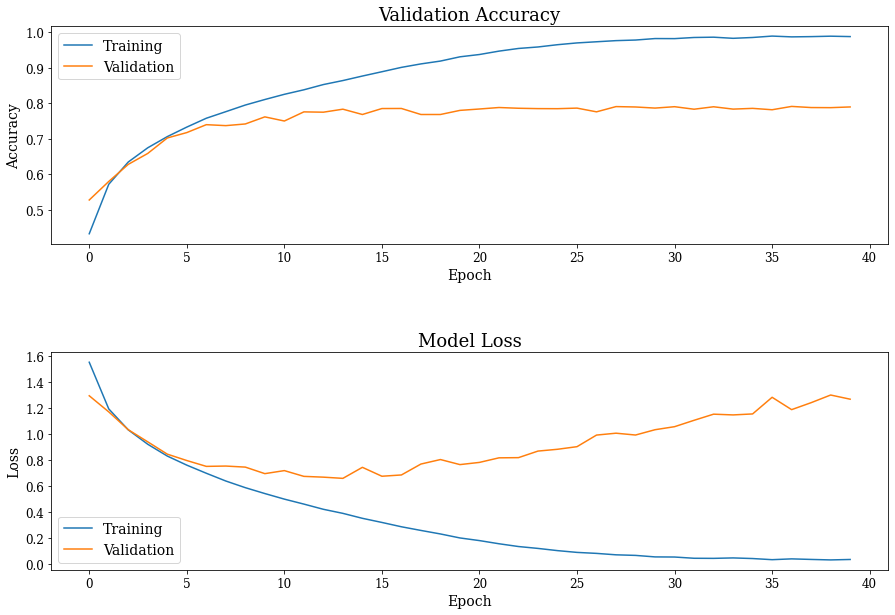

In [52]:
plot_history(history_da1, 'da1.png', metric='accuracy')
model.summary()

*   Define two data augmentation strategies (one more aggressive than the other) and train the model with data augmentation. Clearly state the two augmentation strategies you apply (i.e., the specific transformations). Discuss the training and validation loss curves for the two data augmentation strategies along with the original run without data augmentation. 



# **Data augmentation 2 - Flip vertical; Rotation: 0.6**

In [53]:
# load the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = preprocessing.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

data_augmentation = keras.Sequential(
    [   
        preprocessing.RandomFlip("vertical"),
        preprocessing.RandomRotation(0.6)
    ]
)

Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of validation samples: 10000


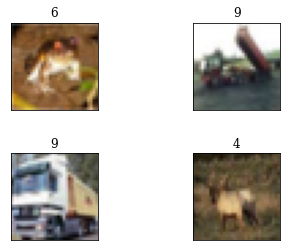

In [50]:
N=2
# fig1 = plt.figure(figsize=(10,10))
# fig1 = plt.imshow(X_train[0], cmap='gray')
start_val = 0 # pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
items = list(range(0, 10))
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    axes[row,col].imshow(X_train[idx], cmap='gray')
    fig.subplots_adjust(hspace=0.5)
    y_target = int(y_train[idx])
    target = str(items[y_target])
    axes[row,col].set_title(target)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])
     

In [54]:
# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = Sequential()
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
# As we use global average pooling, we don't need to use Flatten
model.add(GlobalAveragePooling2D())
model.add(Dense(10, kernel_initializer=initialization))
model.add(Activation('softmax'))


Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = Adam(lr=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
# Use 40 epochs as default value to plot your curves
history_da2 = model.fit(X_train_n, Y_train_class, epochs=40, validation_data=(X_test_n,Y_test_class))

model.save('/content/drive/MyDrive/dl-cw-03/dataAug/da2')

Epoch 1/40


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1563/1563 [==============================] - 31s 18ms/step - loss: 1.8628 - accuracy: 0.3145 - val_loss: 1.6786 - val_accuracy: 0.3881
Epoch 2/40
1563/1563 [==============================] - 28s 18ms/step - loss: 1.6267 - accuracy: 0.4156 - val_loss: 1.5791 - val_accuracy: 0.4369
Epoch 3/40
1563/1563 [==============================] - 27s 18ms/step - loss: 1.5112 - accuracy: 0.4595 - val_loss: 1.4739 - val_accuracy: 0.4753
Epoch 4/40
1563/1563 [==============================] - 28s 18ms/step - loss: 1.4253 - accuracy: 0.4911 - val_loss: 1.3319 - val_accuracy: 0.5203
Epoch 5/40
1563/1563 [==============================] - 28s 18ms/step - loss: 1.3627 - accuracy: 0.5149 - val_loss: 1.3942 - val_accuracy: 0.4971
Epoch 6/40
1563/1563 [==============================] - 27s 18ms/step - loss: 1.3021 - accuracy: 0.5348 - val_loss: 1.3543 - val_accuracy: 0.5377
Epoch 7/40
1563/1563 [==============================] - 28s 18ms/step - loss: 1.2542 - accuracy: 0.5549 - val_loss: 1.2831 - val_accura

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_15 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 activation_16 (Activation)  (None, 16, 16, 64)        0         
                                                      

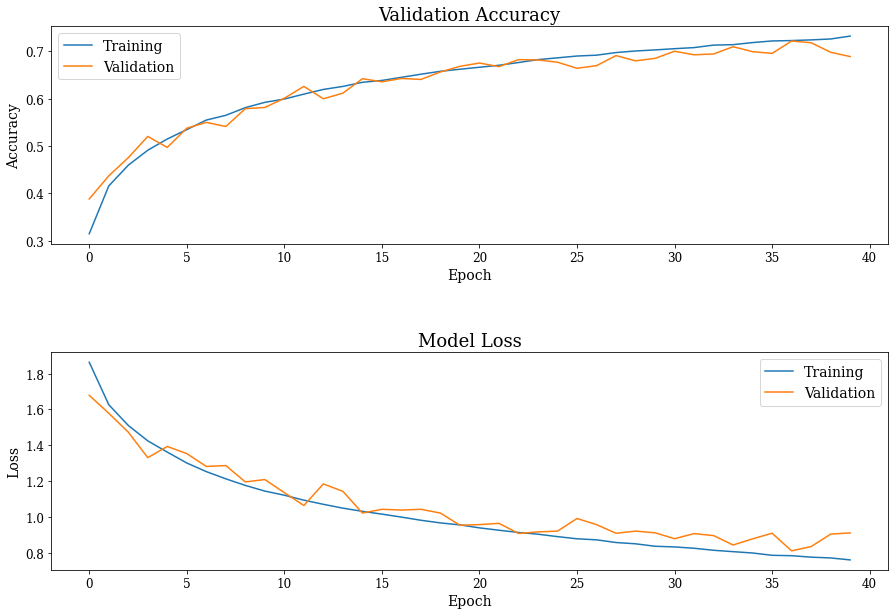

In [55]:
plot_history(history_da2, 'da2.png', metric='accuracy')
model.summary()

# **Data augmentation 3 - Rotation: 0.5; Zoom: 0.4; Translation: -0.2, 0.3, constant, nearest; Contrast: 0.5**

In [60]:
# load the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = preprocessing.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

# You can modify the data_augmentation variable below to add your
# data augmentation pipeline.
# By default we do not apply any augmentation (RandomZoom(0) is equivalent
# to not performing any augmentation)
data_augmentation = keras.Sequential(
    [   
        preprocessing.RandomRotation(0.5),
        preprocessing.RandomZoom(height_factor=0.3),
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.3, fill_mode='constant',interpolation='nearest'),
        # preprocessing.RandomContrast(0.5, seed=123)
    ]
)
# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = Sequential()
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
# As we use global average pooling, we don't need to use Flatten
model.add(GlobalAveragePooling2D())
model.add(Dense(10, kernel_initializer=initialization))
model.add(Activation('softmax'))


Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = Adam(lr=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
# Use 40 epochs as default value to plot your curves
history_da3 = model.fit(X_train_n, Y_train_class, epochs=40, validation_data=(X_test_n,Y_test_class))

model.save('/content/drive/MyDrive/dl-cw-03/dataAug/da3')

Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of validation samples: 10000
Epoch 1/40


1563/1563 [==============================] - 50s 26ms/step - loss: 1.9578 - accuracy: 0.2709 - val_loss: 1.8374 - val_accuracy: 0.3341
Epoch 2/40
1563/1563 [==============================] - 41s 26ms/step - loss: 1.7953 - accuracy: 0.3436 - val_loss: 1.6966 - val_accuracy: 0.3912
Epoch 3/40
1563/1563 [==============================] - 41s 26ms/step - loss: 1.7076 - accuracy: 0.3819 - val_loss: 1.6732 - val_accuracy: 0.4067
Epoch 4/40
1563/1563 [==============================] - 42s 27ms/step - loss: 1.6452 - accuracy: 0.4034 - val_loss: 1.6243 - val_accuracy: 0.4221
Epoch 5/40
1563/1563 [==============================] - 42s 27ms/step - loss: 1.5972 - accuracy: 0.4276 - val_loss: 1.5987 - val_accuracy: 0.4279
Epoch 6/40
1563/1563 [==============================] - 41s 27ms/step - loss: 1.5574 - accuracy: 0.4430 - val_loss: 1.5338 - val_accuracy: 0.4616
Epoch 7/40
1563/1563 [==============================] - 42s 27ms/step - loss: 1.5111 - accuracy: 0.4562 - val_loss: 1.5001 - val_accura

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (None, 32, 32, 3)         0         
                                                                 
 conv2d_24 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_30 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 activation_31 (Activation)  (None, 16, 16, 64)        0         
                                                     

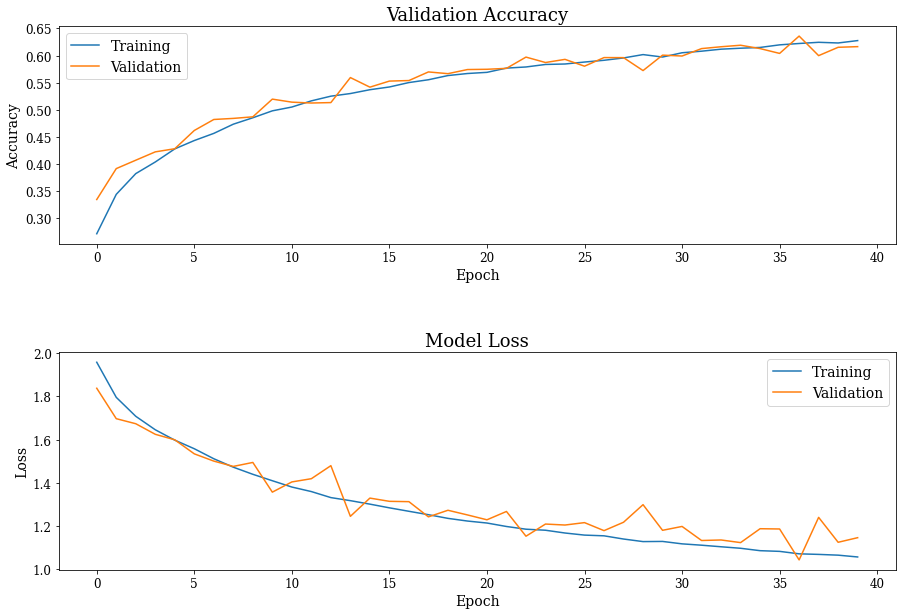

In [61]:
plot_history(history_da3, 'da3.png', metric='accuracy')

model.summary()

*   Attach in the appendix those training and validation curves. 



*   Report in a table the best validation accuracy obtained for the three runs (no data augmentation, data augmentation 1, data augmentation 2).



# **Baseline + Dropout**

In [63]:
print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = preprocessing.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

# You can modify the data_augmentation variable below to add your
# data augmentation pipeline.
# By default we do not apply any augmentation (RandomZoom(0) is equivalent
# to not performing any augmentation)
data_augmentation = keras.Sequential(
    [
        preprocessing.RandomZoom(0)
    ]
)
# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = Sequential()
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(Dropout(0.3))

# As we use global average pooling, we don't need to use Flatten
model.add(GlobalAveragePooling2D())
model.add(Dense(10, kernel_initializer=initialization))
model.add(Activation('softmax'))


Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = Adam(lr=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
# Use 40 epochs as default value to plot your curves
history_dropout = model.fit(X_train_n, Y_train_class, epochs=40, validation_data=(X_test_n,Y_test_class))

model.save('/content/drive/MyDrive/dl-cw-03/reg/dropout')

Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of validation samples: 10000
Epoch 1/40


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1563/1563 [==============================] - 38s 22ms/step - loss: 1.5537 - accuracy: 0.4349 - val_loss: 1.5316 - val_accuracy: 0.5088
Epoch 2/40
1563/1563 [==============================] - 34s 22ms/step - loss: 1.2068 - accuracy: 0.5713 - val_loss: 1.3665 - val_accuracy: 0.5682
Epoch 3/40
1563/1563 [==============================] - 34s 22ms/step - loss: 1.0558 - accuracy: 0.6257 - val_loss: 1.1972 - val_accuracy: 0.6247
Epoch 4/40
1563/1563 [==============================] - 34s 22ms/step - loss: 0.9492 - accuracy: 0.6648 - val_loss: 1.1043 - val_accuracy: 0.6759
Epoch 5/40
1563/1563 [==============================] - 34s 22ms/step - loss: 0.8662 - accuracy: 0.6949 - val_loss: 1.0294 - val_accuracy: 0.6794
Epoch 6/40
1563/1563 [==============================] - 34s 22ms/step - loss: 0.8048 - accuracy: 0.7153 - val_loss: 0.9883 - val_accuracy: 0.6973
Epoch 7/40
1563/1563 [==============================] - 34s 22ms/step - loss: 0.7499 - accuracy: 0.7382 - val_loss: 0.9054 - val_accura

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_14 (Sequential)  (None, 32, 32, 3)         0         
                                                                 
 conv2d_28 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_35 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 16, 16, 64)        18496     
                                                     

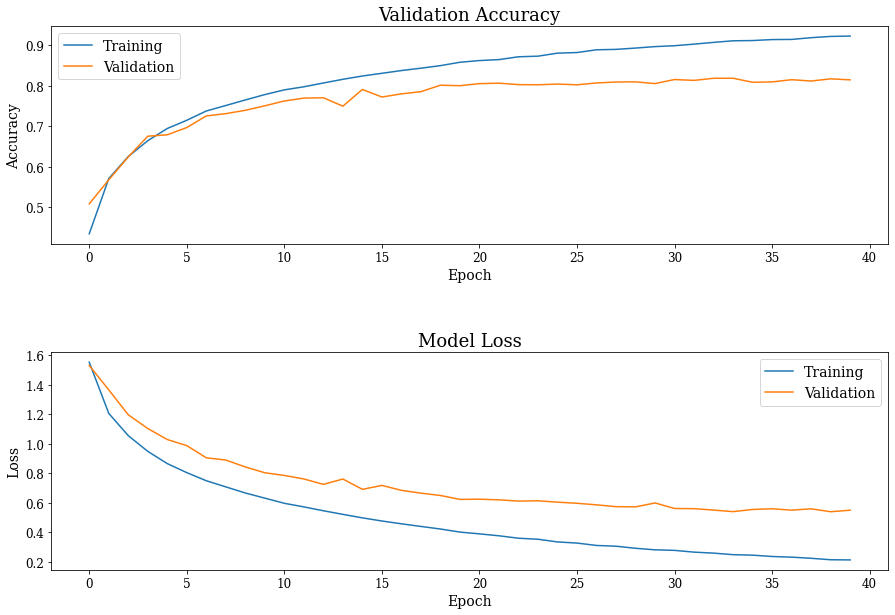

In [64]:
plot_history(history_dropout, 'dropout.png', metric='accuracy')
model.summary()

# **Baseline + Batch Normalization**

In [65]:
# load the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = preprocessing.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

# You can modify the data_augmentation variable below to add your
# data augmentation pipeline.
# By default we do not apply any augmentation (RandomZoom(0) is equivalent
# to not performing any augmentation)
data_augmentation = keras.Sequential(
    [
        preprocessing.RandomZoom(0)
    ]
)
# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = Sequential()
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('relu'))
# As we use global average pooling, we don't need to use Flatten
model.add(GlobalAveragePooling2D())
model.add(Dense(10, kernel_initializer=initialization))
model.add(Activation('softmax'))

Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = Adam(lr=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Use 40 epochs as default value to plot your curves
history_batchn = model.fit(X_train_n, Y_train_class, epochs=40, validation_data=(X_test_n,Y_test_class))

model.save('/content/drive/MyDrive/dl-cw-03/reg/batchn')

Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of validation samples: 10000
Epoch 1/40


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1563/1563 [==============================] - 36s 21ms/step - loss: 1.2575 - accuracy: 0.5501 - val_loss: 1.1509 - val_accuracy: 0.5864
Epoch 2/40
1563/1563 [==============================] - 33s 21ms/step - loss: 0.9090 - accuracy: 0.6826 - val_loss: 0.9285 - val_accuracy: 0.6738
Epoch 3/40
1563/1563 [==============================] - 33s 21ms/step - loss: 0.7654 - accuracy: 0.7347 - val_loss: 0.9329 - val_accuracy: 0.6758
Epoch 4/40
1563/1563 [==============================] - 33s 21ms/step - loss: 0.6687 - accuracy: 0.7712 - val_loss: 0.8441 - val_accuracy: 0.7106
Epoch 5/40
1563/1563 [==============================] - 33s 21ms/step - loss: 0.5935 - accuracy: 0.7954 - val_loss: 0.8167 - val_accuracy: 0.7177
Epoch 6/40
1563/1563 [==============================] - 33s 21ms/step - loss: 0.5322 - accuracy: 0.8168 - val_loss: 0.8587 - val_accuracy: 0.7109
Epoch 7/40
1563/1563 [==============================] - 33s 21ms/step - loss: 0.4766 - accuracy: 0.8377 - val_loss: 0.9321 - val_accura

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_16 (Sequential)  (None, 32, 32, 3)         0         
                                                                 
 conv2d_32 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_40 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 64)       256       
 ormalization)                                       

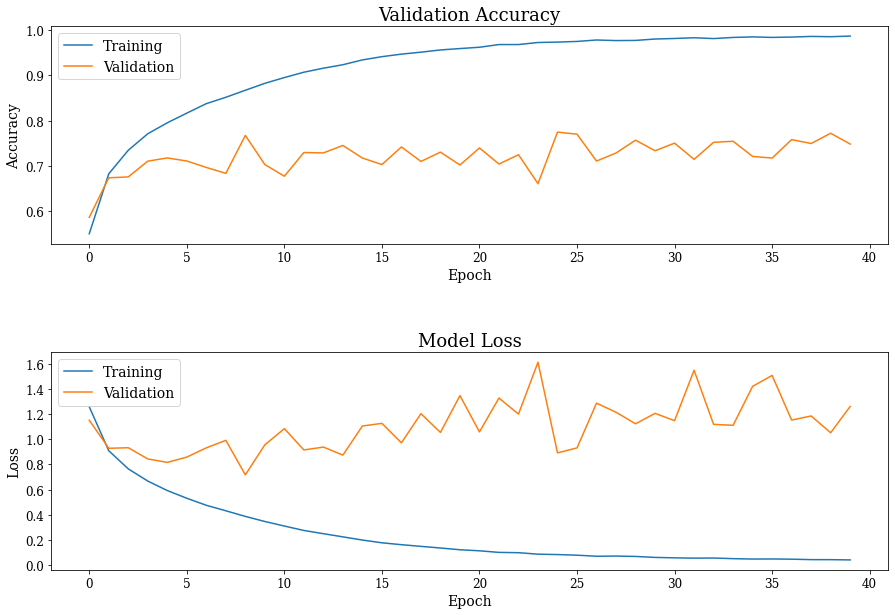

In [66]:
plot_history(history_batchn, 'batchn.png', metric='accuracy')
model.summary()

# **Baseline + Dropout + Batch Normalization** 

In [3]:
# load the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = preprocessing.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

# You can modify the data_augmentation variable below to add your
# data augmentation pipeline.
# By default we do not apply any augmentation (RandomZoom(0) is equivalent
# to not performing any augmentation)
data_augmentation = keras.Sequential(
    [
        preprocessing.RandomZoom(0)
    ]
)
# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = Sequential()
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
# As we use global average pooling, we don't need to use Flatten
model.add(GlobalAveragePooling2D())
model.add(Dense(10, kernel_initializer=initialization))
model.add(Activation('softmax'))


Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = Adam(lr=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
# Use 40 epochs as default value to plot your curves
history_batchdrop = model.fit(X_train_n, Y_train_class, epochs=40, validation_data=(X_test_n,Y_test_class))

model.save('/content/drive/MyDrive/dl-cw-03/reg/batchdrop')

170498071/170498071 [==============================] - 2s 0us/step
Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of validation samples: 10000
Epoch 1/40


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1563/1563 [==============================] - 47s 28ms/step - loss: 1.3359 - accuracy: 0.5198 - val_loss: 2.3177 - val_accuracy: 0.2472
Epoch 2/40
1563/1563 [==============================] - 43s 27ms/step - loss: 1.0340 - accuracy: 0.6326 - val_loss: 2.5791 - val_accuracy: 0.2320
Epoch 3/40
1563/1563 [==============================] - 44s 28ms/step - loss: 0.9159 - accuracy: 0.6765 - val_loss: 2.1691 - val_accuracy: 0.3199
Epoch 4/40
1563/1563 [==============================] - 43s 27ms/step - loss: 0.8343 - accuracy: 0.7074 - val_loss: 1.9191 - val_accuracy: 0.3636
Epoch 5/40
1563/1563 [==============================] - 43s 27ms/step - loss: 0.7781 - accuracy: 0.7274 - val_loss: 1.8126 - val_accuracy: 0.3976
Epoch 6/40
1563/1563 [==============================] - 43s 28ms/step - loss: 0.7289 - accuracy: 0.7448 - val_loss: 1.7431 - val_accuracy: 0.4376
Epoch 7/40
1563/1563 [==============================] - 43s 28ms/step - loss: 0.6913 - accuracy: 0.7600 - val_loss: 1.7769 - val_accura

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                    

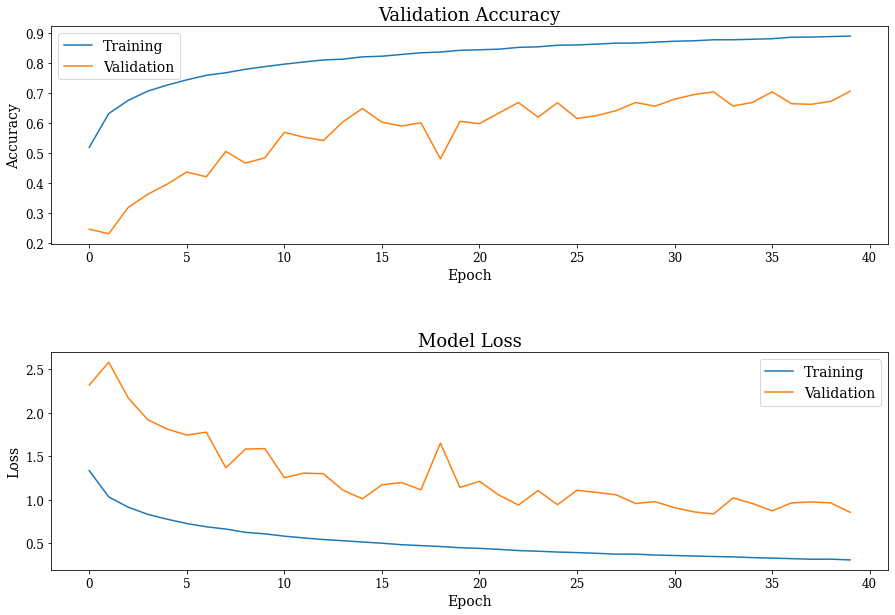

In [4]:
plot_history(history_batchdrop, 'batchdrop.png', metric='accuracy')
model.summary()

In [2]:
# load the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = preprocessing.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

# You can modify the data_augmentation variable below to add your
# data augmentation pipeline.
# By default we do not apply any augmentation (RandomZoom(0) is equivalent
# to not performing any augmentation)
data_augmentation = keras.Sequential(
    [
        preprocessing.RandomZoom(0)
    ]
)
# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = Sequential()
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
# As we use global average pooling, we don't need to use Flatten
model.add(GlobalAveragePooling2D())
model.add(Dense(10, kernel_initializer=initialization))
model.add(Activation('softmax'))


Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = Adam(lr=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
# Use 40 epochs as default value to plot your curves
history_batchdrop2 = model.fit(X_train_n, Y_train_class, epochs=40, validation_data=(X_test_n,Y_test_class))

model.save('/content/drive/MyDrive/dl-cw-03/reg/batchdrop2')

170498071/170498071 [==============================] - 2s 0us/step
Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of validation samples: 10000
Epoch 1/40


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1563/1563 [==============================] - 46s 27ms/step - loss: 1.2458 - accuracy: 0.5552 - val_loss: 1.1539 - val_accuracy: 0.5888
Epoch 2/40
1563/1563 [==============================] - 42s 27ms/step - loss: 0.9350 - accuracy: 0.6738 - val_loss: 1.1649 - val_accuracy: 0.5838
Epoch 3/40
1563/1563 [==============================] - 42s 27ms/step - loss: 0.7978 - accuracy: 0.7219 - val_loss: 0.9084 - val_accuracy: 0.6835
Epoch 4/40
1563/1563 [==============================] - 42s 27ms/step - loss: 0.7072 - accuracy: 0.7555 - val_loss: 0.8551 - val_accuracy: 0.6971
Epoch 5/40
1563/1563 [==============================] - 42s 27ms/step - loss: 0.6470 - accuracy: 0.7752 - val_loss: 0.8998 - val_accuracy: 0.6887
Epoch 6/40
1563/1563 [==============================] - 42s 27ms/step - loss: 0.5968 - accuracy: 0.7953 - val_loss: 0.7711 - val_accuracy: 0.7282
Epoch 7/40
1563/1563 [==============================] - 42s 27ms/step - loss: 0.5514 - accuracy: 0.8077 - val_loss: 0.9400 - val_accura

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                    

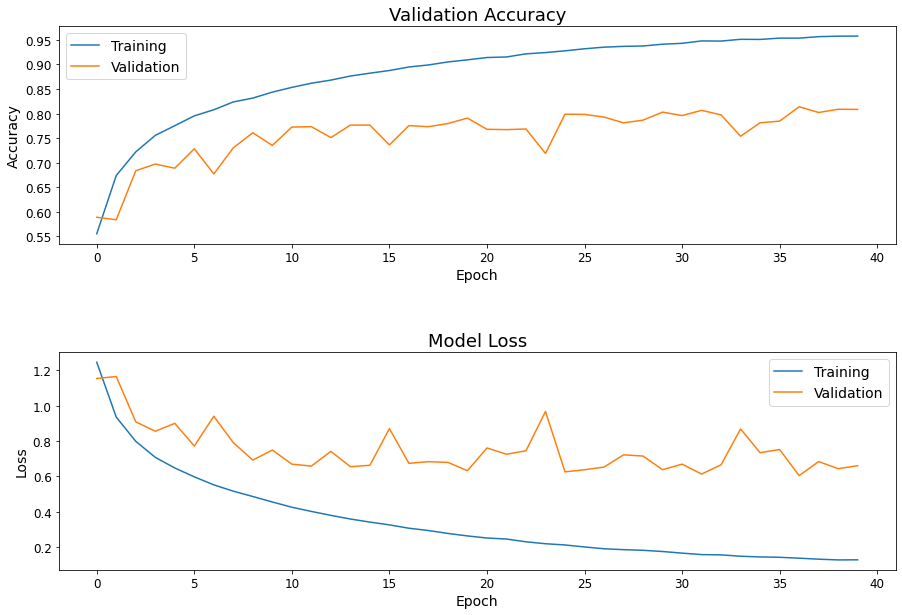

In [3]:
plot_history(history_batchdrop2, 'batchdrop2.png', metric='accuracy')
model.summary()

In [4]:
# load the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = preprocessing.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

# You can modify the data_augmentation variable below to add your
# data augmentation pipeline.
# By default we do not apply any augmentation (RandomZoom(0) is equivalent
# to not performing any augmentation)
data_augmentation = keras.Sequential(
    [
        preprocessing.RandomZoom(0)
    ]
)
# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = Sequential()
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(Dropout(0.3))
# As we use global average pooling, we don't need to use Flatten
model.add(GlobalAveragePooling2D())
model.add(Dense(10, kernel_initializer=initialization))
model.add(Activation('softmax'))


Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = Adam(lr=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
# Use 40 epochs as default value to plot your curves
history_batchdrop3 = model.fit(X_train_n, Y_train_class, epochs=40, validation_data=(X_test_n,Y_test_class))

model.save('/content/drive/MyDrive/dl-cw-03/reg/batchdrop3')

Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of validation samples: 10000
Epoch 1/40


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1563/1563 [==============================] - 36s 22ms/step - loss: 1.3960 - accuracy: 0.4919 - val_loss: 1.1841 - val_accuracy: 0.5699
Epoch 2/40
1563/1563 [==============================] - 33s 21ms/step - loss: 1.0503 - accuracy: 0.6276 - val_loss: 1.0436 - val_accuracy: 0.6194
Epoch 3/40
1563/1563 [==============================] - 33s 21ms/step - loss: 0.9027 - accuracy: 0.6801 - val_loss: 0.9215 - val_accuracy: 0.6736
Epoch 4/40
1563/1563 [==============================] - 34s 22ms/step - loss: 0.8053 - accuracy: 0.7154 - val_loss: 0.8226 - val_accuracy: 0.7105
Epoch 5/40
1563/1563 [==============================] - 33s 21ms/step - loss: 0.7373 - accuracy: 0.7415 - val_loss: 0.8357 - val_accuracy: 0.7145
Epoch 6/40
1563/1563 [==============================] - 33s 21ms/step - loss: 0.6837 - accuracy: 0.7630 - val_loss: 0.7477 - val_accuracy: 0.7365
Epoch 7/40
1563/1563 [==============================] - 33s 21ms/step - loss: 0.6394 - accuracy: 0.7768 - val_loss: 0.7854 - val_accura

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)       

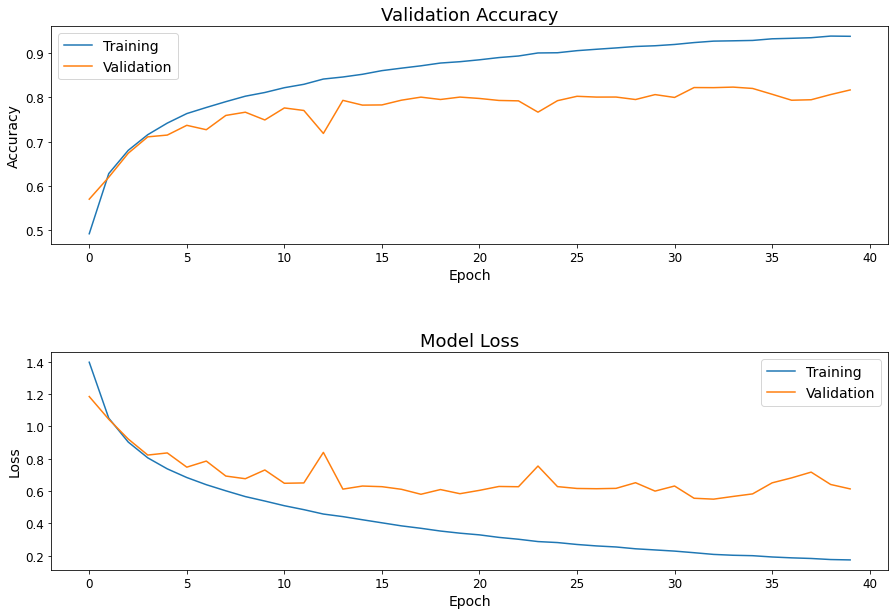

In [5]:
plot_history(history_batchdrop3, 'batchdrop3.png', metric='accuracy')
model.summary()

In [7]:
# load the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = preprocessing.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

# You can modify the data_augmentation variable below to add your
# data augmentation pipeline.
# By default we do not apply any augmentation (RandomZoom(0) is equivalent
# to not performing any augmentation)
data_augmentation = keras.Sequential(
    [
        preprocessing.RandomZoom(0)
    ]
)
# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = Sequential()
model.add(data_augmentation)
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
# As we use global average pooling, we don't need to use Flatten
model.add(GlobalAveragePooling2D())
model.add(Dense(10, kernel_initializer=initialization))
model.add(Activation('softmax'))


Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = Adam(lr=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
# Use 40 epochs as default value to plot your curves
history_batchdrop4 = model.fit(X_train_n, Y_train_class, epochs=40, validation_data=(X_test_n,Y_test_class))

model.save('/content/drive/MyDrive/dl-cw-03/reg/batchdrop4')

Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of validation samples: 10000
Epoch 1/40


1563/1563 [==============================] - 45s 27ms/step - loss: 1.3091 - accuracy: 0.5325 - val_loss: 1.3651 - val_accuracy: 0.4927
Epoch 2/40
1563/1563 [==============================] - 42s 27ms/step - loss: 0.9919 - accuracy: 0.6511 - val_loss: 1.3920 - val_accuracy: 0.5138
Epoch 3/40
1563/1563 [==============================] - 42s 27ms/step - loss: 0.8605 - accuracy: 0.6998 - val_loss: 1.0447 - val_accuracy: 0.6278
Epoch 4/40
1563/1563 [==============================] - 42s 27ms/step - loss: 0.7802 - accuracy: 0.7309 - val_loss: 1.0202 - val_accuracy: 0.6216
Epoch 5/40
1563/1563 [==============================] - 42s 27ms/step - loss: 0.7183 - accuracy: 0.7513 - val_loss: 1.0135 - val_accuracy: 0.6405
Epoch 6/40
1563/1563 [==============================] - 42s 27ms/step - loss: 0.6771 - accuracy: 0.7640 - val_loss: 0.7533 - val_accuracy: 0.7425
Epoch 7/40
1563/1563 [==============================] - 42s 27ms/step - loss: 0.6321 - accuracy: 0.7815 - val_loss: 0.7730 - val_accura

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_14 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 activation_20 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 16, 64)       

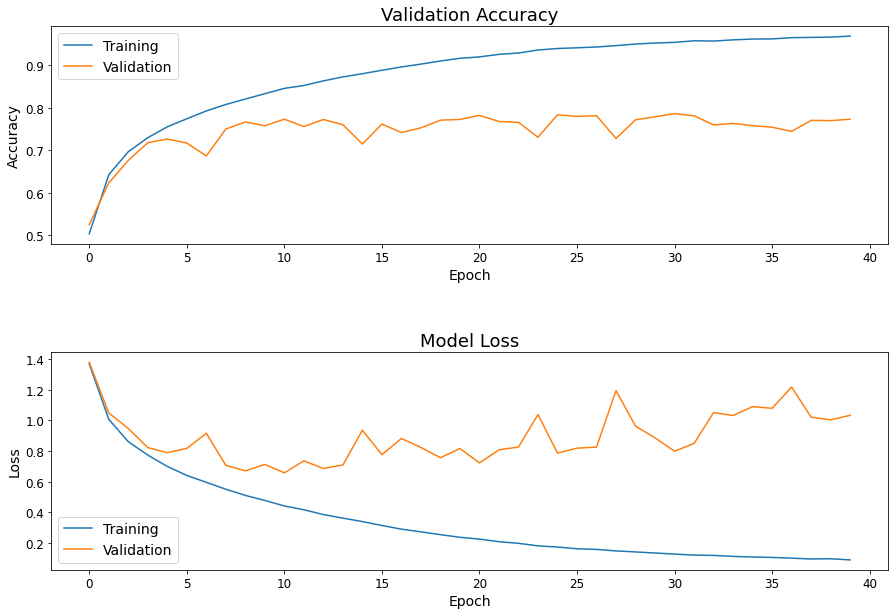

In [9]:
plot_history(history_batchdrop4, 'batchdrop4.png', metric='accuracy')
model.summary()

In [2]:
# load the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = preprocessing.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

# You can modify the data_augmentation variable below to add your
# data augmentation pipeline.
# By default we do not apply any augmentation (RandomZoom(0) is equivalent
# to not performing any augmentation)
data_augmentation = keras.Sequential(
    [
        preprocessing.RandomZoom(0)
    ]
)
# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = Sequential()
model.add(data_augmentation)
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# As we use global average pooling, we don't need to use Flatten
model.add(GlobalAveragePooling2D())
model.add(Dense(10, kernel_initializer=initialization))
model.add(Activation('softmax'))


Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = Adam(lr=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
# Use 40 epochs as default value to plot your curves
history_batchdrop5 = model.fit(X_train_n, Y_train_class, epochs=40, validation_data=(X_test_n,Y_test_class))

model.save('/content/drive/MyDrive/dl-cw-03/reg/batchdrop5')

170498071/170498071 [==============================] - 2s 0us/step
Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of validation samples: 10000


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/40


1563/1563 [==============================] - 35s 21ms/step - loss: 1.5885 - accuracy: 0.4190 - val_loss: 1.2995 - val_accuracy: 0.5360
Epoch 2/40
1563/1563 [==============================] - 32s 21ms/step - loss: 1.2243 - accuracy: 0.5634 - val_loss: 1.0985 - val_accuracy: 0.6130
Epoch 3/40
1563/1563 [==============================] - 32s 21ms/step - loss: 1.0615 - accuracy: 0.6247 - val_loss: 1.0166 - val_accuracy: 0.6394
Epoch 4/40
1563/1563 [==============================] - 32s 21ms/step - loss: 0.9461 - accuracy: 0.6669 - val_loss: 0.8908 - val_accuracy: 0.6843
Epoch 5/40
1563/1563 [==============================] - 32s 20ms/step - loss: 0.8620 - accuracy: 0.6973 - val_loss: 0.8546 - val_accuracy: 0.6961
Epoch 6/40
1563/1563 [==============================] - 32s 20ms/step - loss: 0.7920 - accuracy: 0.7217 - val_loss: 0.8078 - val_accuracy: 0.7154
Epoch 7/40
1563/1563 [==============================] - 33s 21ms/step - loss: 0.7319 - accuracy: 0.7435 - val_loss: 0.7744 - val_accura

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)       

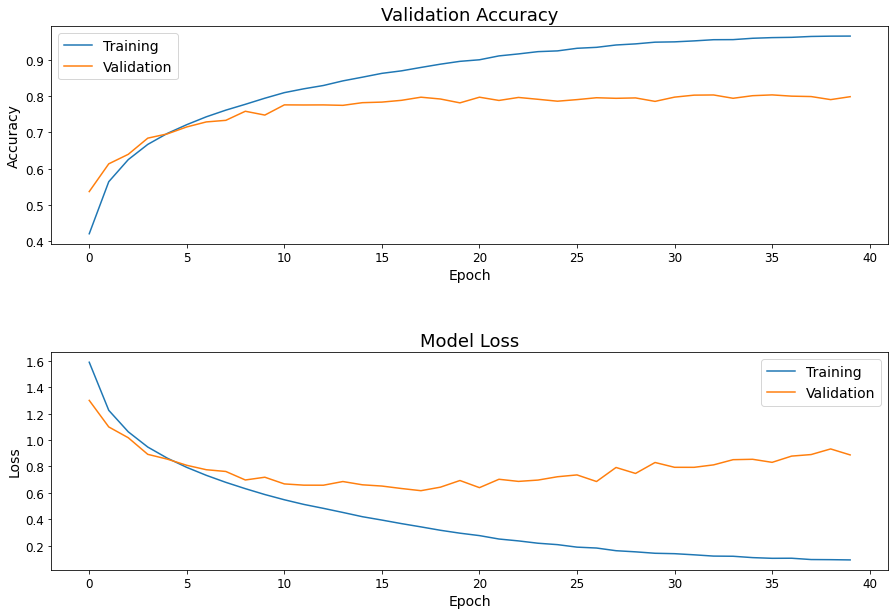

In [3]:
plot_history(history_batchdrop5, 'batchdrop5.png', metric='accuracy')
model.summary()